In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.applications import ResNet50 
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BUCKET = 21
IMAGE_SIZE = (224, 224)
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64

In [4]:
gdrive_dir = "/content/drive/MyDrive"
working_dir = os.path.join(gdrive_dir, "CS3244 Project")
data_root_dir = os.path.join(working_dir, "landmarks/international/data_split")
data_dir = os.path.join(data_root_dir, str(BUCKET))
model_root_dir = os.path.join(working_dir, "models/haochen")

In [5]:
print('number of local labels:', len(os.listdir(data_dir)))

number of local labels: 200


In [6]:
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, interpolation="bilinear")

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, 
    validation_split = VALIDATION_SPLIT,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range = [0.9,1.1],
    fill_mode = 'nearest'
)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset = "training", 
    shuffle = True, 
    target_size = IMAGE_SIZE ,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = VALIDATION_SPLIT
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    subset = "validation", 
    shuffle = False, 
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 1500 images belonging to 200 classes.
Found 290 images belonging to 200 classes.


In [7]:
resnet_model = ResNet50()

102973440/102967424 [==============================] - 1s 0us/step


In [8]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [9]:
last_layer = resnet_model.get_layer("predictions")
last_output = last_layer.output

In [10]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(200, activation='softmax')(x)

model = Model(resnet_model.input, x)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
load_model_dir = os.path.join(model_root_dir, "restnet50_classification_v1_international_bucket_20")
model = tf.keras.models.load_model(load_model_dir)

In [13]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
    metrics = ['accuracy']
)

steps_per_epoch = int(train_generator.samples / BATCH_SIZE)
validation_steps = int(validation_generator.samples / BATCH_SIZE)

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 23
Validation steps: 4


In [14]:
history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = validation_steps
)

Epoch 1/30
23/23 [==============================] - 644s 26s/step - loss: 8.8413 - accuracy: 0.0236 - val_loss: 16.1185 - val_accuracy: 0.0430
Epoch 2/30
23/23 [==============================] - 58s 3s/step - loss: 4.4466 - accuracy: 0.1557 - val_loss: 5.7391 - val_accuracy: 0.0664
Epoch 3/30
23/23 [==============================] - 59s 3s/step - loss: 3.7702 - accuracy: 0.2480 - val_loss: 5.3504 - val_accuracy: 0.2070
Epoch 4/30
23/23 [==============================] - 60s 3s/step - loss: 3.0380 - accuracy: 0.3822 - val_loss: 3.2442 - val_accuracy: 0.4062
Epoch 5/30
23/23 [==============================] - 60s 3s/step - loss: 2.5216 - accuracy: 0.4618 - val_loss: 3.3165 - val_accuracy: 0.4102
Epoch 6/30
23/23 [==============================] - 60s 3s/step - loss: 2.1315 - accuracy: 0.5532 - val_loss: 3.4914 - val_accuracy: 0.3672
Epoch 7/30
23/23 [==============================] - 60s 3s/step - loss: 1.7221 - accuracy: 0.6160 - val_loss: 4.1543 - val_accuracy: 0.2656
Epoch 8/30
23/23 

In [15]:
save_model_dir = os.path.join(model_root_dir, "restnet50_classification_v1_international_bucket_21")
model.save(save_model_dir)
df = pd.DataFrame(history.history)
hist_dir = os.path.join(model_root_dir, "history/international_bucket_21.csv")
df.to_csv(hist_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS3244 Project/models/haochen/restnet50_classification_v1_international_bucket_21/assets


Text(0.5, 1.0, 'Training and validation loss')

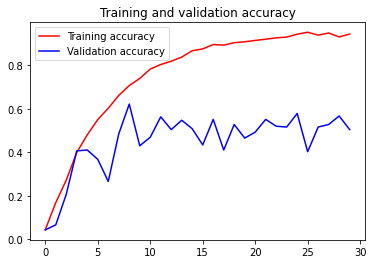

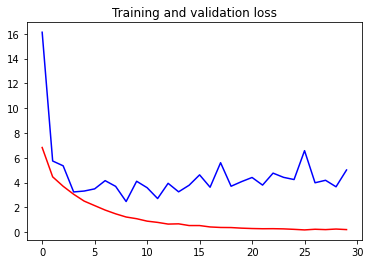

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')